In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import transform_feature
from DataBaseControl import DataBaseControl
import model
from functools import reduce
from sklearn.preprocessing import MinMaxScaler

</b>기술적 지표 선택 기준</b>
* 피쳐는 기본적인 ohlcv와 더불어 대표적으로 사용되는 기술적 지표들은 OBV, RSI, MACD, Stochastic, William 지표를 활용했다.
* 피쳐 선택 또한 신중히 해야하나 금융 쪽 도메인에 대한 명확한 이해가 없어 각종 논문이나 서적에서 자주 참고하는 지표를 채택했다.
* https://github.com/areed1192/sigma_coding_youtube/blob/master/python/python-data-science/machine-learning/random-forest/random_forest_price_prediction.ipynb (해당 노트북으로 부터 많은 아이디어를 참고했다.)

In [2]:

db_control = DataBaseControl("raw","BTCUSD", "1d")
bit =  db_control.get_df("*")
bit = bit.loc[~bit.index.duplicated()]
bit.dropna(inplace=True)
bit.drop_duplicates(inplace=True)
transformer = transform_feature.FeatureTransformer(adj_close=bit['Adj Close'], high=bit['High'], low=bit['Low'], volume=bit['Volume'])
transformer.transform(bit, is_coin = True)
bit

Create new feature complete


,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William
Date,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643
2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489,36.713965,60.948847,-8.155219,1795320827102,-92.921565


<b>비트코인 데이터 이외</b>
* 비트코인 가격만으로 학습을 시킬 경우 외부 상황이나 경제적 이슈에 대응하지 못할 수 있기에 대표적인 경제 지표들은 학습 가능하게 추가해뒀다.
* 비트코인 가격이외 추가적으로 사용하는 피쳐는 나스닥 etf인 qqq, 미국 10년물 국채 금리, 금 선물 가격, 달러 인덱스, VIX 지수이다.


In [3]:
vix = db_control.get_df("Date","Close", table_name="VIX_1d")
usd = db_control.get_df("Date","Close", table_name="DXF_1d")
tnx = db_control.get_df("Date","Close", table_name="TNX_1d")
gld = db_control.get_df("Date","Close", table_name="GCF_1d")
qqq = db_control.get_df("Date","Close", table_name="QQQ_1d")
ovx = db_control.get_df("Date","Close", table_name="OVX_1d")

data_frames = [bit, vix, usd, tnx, qqq, gld, ovx]
for df, ticker in zip(data_frames[1:], ["VIX","USD","TNX" ,"QQQ", "GOLD","OVX"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]


In [4]:
df = reduce(lambda left, right: left.join(right), data_frames)
df

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close
Date,,,,,,,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762,NaN,NaN,NaN,104.400002,NaN,NaN
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210,NaN,NaN,NaN,104.779999,NaN,NaN
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211,NaN,NaN,NaN,106.000000,NaN,NaN
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730,NaN,NaN,NaN,106.910004,NaN,NaN
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841,25.420000,102.594002,2.917,329.600006,1867.000000,53.150002
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643,31.200001,103.802002,3.066,313.000000,1874.000000,54.720001
2022-05-06,36573.183594,36624.359375,35482.132812,36040.921875,36040.921875,37795577489,36.713965,60.948847,-8.155219,1795320827102,-92.921565,30.190001,103.680000,3.123,309.250000,1881.199951,54.820000


In [5]:
new_df = df.loc[~df.index.duplicated()]
new_df = new_df.ffill()
new_df['Target'] = np.sign(new_df['Adj Close'].diff()).shift(-1)
new_df.dropna(inplace=True)
new_df

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close,Target
Date,,,,,,,,,,,,,,,,,,
2015-02-27,236.436005,256.653015,236.436005,253.828003,253.828003,44013900,58.602115,0.924069,7.405871,-91677804,-21.984833,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-02-28,253.520004,254.692001,249.479004,254.263000,254.263000,13949300,58.802083,0.921736,5.818138,-77728504,-22.300819,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-03-01,254.283005,261.660004,245.932999,260.201996,260.201996,25213700,61.534015,0.934267,6.736835,-52514804,-10.629639,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-03-02,260.356995,276.300995,258.312988,275.670013,275.670013,40465700,67.566482,0.968223,12.732797,-12049104,-1.024720,13.040000,95.478996,2.084,109.379997,1207.699951,54.919998,1.0
2015-03-03,275.045990,285.795990,268.161011,281.701996,281.701996,50461300,69.570593,0.980679,19.376884,38412196,-5.760430,13.860000,95.407997,2.122,108.870003,1204.000000,53.049999,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,38528.109375,38629.996094,37585.621094,37750.453125,37750.453125,27326943244,38.879318,61.988710,-4.354879,1839468256418,-97.928917,29.250000,103.496002,2.960,318.820007,1868.800049,54.040001,1.0
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490,48.365955,61.845985,-1.878322,1876222660908,-65.365841,25.420000,102.594002,2.917,329.600006,1867.000000,53.150002,-1.0
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317,38.143361,61.370995,-4.046230,1833116404591,-90.443643,31.200001,103.802002,3.066,313.000000,1874.000000,54.720001,-1.0


<b>최종 데이터 설명</b>
* 모델 학습을 위한 데이터는 2015.02.10~2022.05.07까지 약 7년 간 1일 간격의 데이터이다.
* 주식이나 금리 데이터 등의 경우 주말 데이터가 존재하지 않아 데이터의 수가 더 적어야 하지만,
부족한 데이터 수를 매워보고자 금요일의 데이터를 복사해 넣는 방식으로 데이터를 구성했다.
* 결측치나 중복이 발생한 데이터를 제외하고 총 데이터는 2626개로 구성된다.

<b>모델 설명</b>
* 모델은 랜덤 포레스트 분류기를 사용할 것이며 모델이 예측하는 값은 내일 비트코인이 상승인지 하락인지이다.
* 랜덤 포레스트를 사용한 까닭과 회귀를 통한 가격 예측이 아닌 분류를 사용한 이유는 정확도 때문이다.
* 모델의 학습 방식은 다음과 같다.
    * 모델은 120일 단위로 학습을 진행한다. 
    * 모델의 학습은 매일 이뤄지며 오늘까지의 총 120일간의 데이터로 다음날 방향성을 예측한다.

In [6]:
X = new_df.drop(['Target'],axis=1)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [7]:
SIZE = 120
feature_res = pd.DataFrame(columns= X.columns)
pred = []
f1_res = pd.DataFrame()
total_pred = []
for i in range(len(new_df) - SIZE - 1):
    train_X = X.iloc[i: i + SIZE]
    train_y = new_df['Target'].iloc[i: i + SIZE]

    test_X = X.iloc[i + SIZE]
    test_y = new_df['Target'].iloc[i + SIZE]

    rf_model = RandomForestClassifier(n_jobs=-1)
    rf_model.fit(train_X, train_y)

    pred_value = rf_model.predict([test_X])[0]
    pred.append(pred_value)
    total_pred.append(pred_value)

    if len(pred) == SIZE:
        target = new_df['Target'].iloc[i : i + SIZE]
        feature_imp = pd.DataFrame(data=rf_model.feature_importances_).T
        feature_imp.columns=train_X.columns
        feature_res = pd.concat([feature_res, feature_imp])

        cls_report = classification_report(target, pred, output_dict=True, target_names=["up", "down"], labels=[1,-1])
        up_report = pd.DataFrame([cls_report["up"]])
        down_report = pd.DataFrame([cls_report["down"]])

        up_report.columns = ["up_" + c for c in up_report]
        down_report.columns = ["down_" + c for c in down_report]

        cls_report = pd.concat([up_report, down_report], axis=1)
        f1_res = f1_res.append(cls_report)
        
        pred = []
        


In [23]:
f1_res.describe()

,up_precision,up_recall,up_f1-score,up_support,down_precision,down_recall,down_f1-score,down_support
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.653177,0.631712,0.638992,65.650000,0.569244,0.590875,0.576257,54.300000
std,0.075658,0.072236,0.059124,7.499298,0.080155,0.097975,0.075645,7.595705
min,0.539474,0.500000,0.566038,56.000000,0.408163,0.375000,0.420000,40.000000
25%,0.598437,0.583732,0.592599,60.000000,0.511344,0.530256,0.532416,50.500000
50%,0.653662,0.634023,0.624765,64.000000,0.586127,0.598015,0.577955,56.000000
75%,0.709621,0.674765,0.668000,69.500000,0.609483,0.659013,0.636479,60.000000
max,0.791667,0.808824,0.769231,79.000000,0.711111,0.754386,0.660714,64.000000


In [24]:
feature_res.describe()

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.063676,0.056331,0.057028,0.059206,0.057310,0.075403,0.064313,0.058700,0.065465,0.078560,0.063623,0.047572,0.055167,0.048561,0.049274,0.048847,0.050964
std,0.010147,0.008665,0.009135,0.012027,0.011074,0.014556,0.007956,0.009403,0.014580,0.018126,0.010156,0.009789,0.014945,0.009535,0.012287,0.014134,0.008757
min,0.044951,0.042959,0.041038,0.042208,0.040848,0.050844,0.043932,0.044019,0.046812,0.048829,0.045689,0.033018,0.033425,0.032201,0.034767,0.032386,0.040628
25%,0.058749,0.048839,0.052945,0.053579,0.048598,0.065323,0.059900,0.050409,0.056995,0.061931,0.055837,0.040380,0.047804,0.041574,0.039009,0.041776,0.045098
50%,0.063046,0.056474,0.056531,0.056525,0.056534,0.071057,0.065314,0.055239,0.062298,0.083957,0.064388,0.046157,0.051963,0.048997,0.043712,0.044259,0.050418
75%,0.065531,0.061408,0.061940,0.064293,0.061061,0.082953,0.067506,0.066662,0.068672,0.089763,0.070457,0.053152,0.058542,0.050688,0.059546,0.050145,0.053407
max,0.089160,0.074358,0.074621,0.085350,0.090915,0.113512,0.081070,0.075033,0.111586,0.118548,0.083797,0.066187,0.098876,0.071831,0.073727,0.095087,0.075344


Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

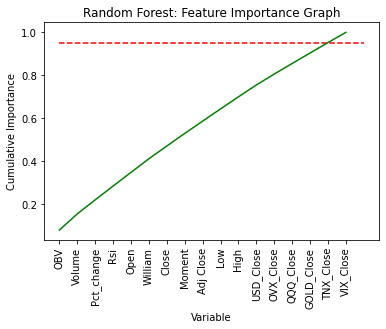

In [25]:
# Cumulative importances
cumulative_importances = feature_res.mean().sort_values(ascending=False).cumsum()

# Make a line graph

plt.plot(cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(cumulative_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

<b>결과 설명</b>
* 모델의 정확도 자체는 준수한 편이다. 평균적인 f1_score는 0.6정도이다.
* 피쳐는 볼륨(거래량)과 연관된 지표에 크게 영향을 받는다.
* 비트코인이 아닌 지표들 중에는 미국 달러와 금이 영향을 크게 미치는 요소이다.


In [26]:
date_index = new_df.index[SIZE: len(total_pred) + SIZE]
pred_series = pd.Series(index=date_index, data=total_pred)
target = new_df['Target'].loc[date_index]

In [61]:
pred_series.to_csv("pred.csv")
new_df.to_csv("new_df.csv")

In [28]:
def get_trade_point(pred): 
    """ 예측 데이터와 실제 가격의 증감률의 차이에 따라 투자 조건을 다르게 했을 때의
        달라지는 수익률 곡선을 구해준다.
    """
    long_point = [] 
    short_point = [] 
    before = 1
    for date, value in pred.items():
        # if value * before < 0:
        if value > 0:
            long_point.append(date)
        else:
            short_point.append(date)
        # before = value
    
    return long_point, short_point

def get_profit(in_point, is_short=False):
    out_point = [new_df.index.get_loc(p) + 1 for p in in_point]
    if out_point[-1] >= len(new_df):
        out_point = out_point[:-1]
        in_point = in_point[:-1]
    if is_short:
        profit = (new_df['Adj Close'].loc[in_point].values - new_df['Adj Close'].iloc[out_point].values).cumsum()
    else:
        profit = (new_df['Adj Close'].iloc[out_point].values - new_df['Adj Close'].loc[in_point].values).cumsum()
    return profit

long_point, short_point = get_trade_point(pred_series)
target_long_point, target_short_point = get_trade_point(target)



In [29]:
def plot_point(long_point, short_point, days=300):
    out_value = new_df['Adj Close'].loc[short_point]
    in_value = new_df['Adj Close'].loc[long_point]
    plt.figure(figsize=(16,10))
    plt.plot(df['Adj Close'])
    plt.scatter(x=short_point, y = out_value, c='b')
    plt.scatter(x=long_point, y = in_value, c='r')
    plt.xlim(new_df.index[-days], new_df.index[-SIZE])


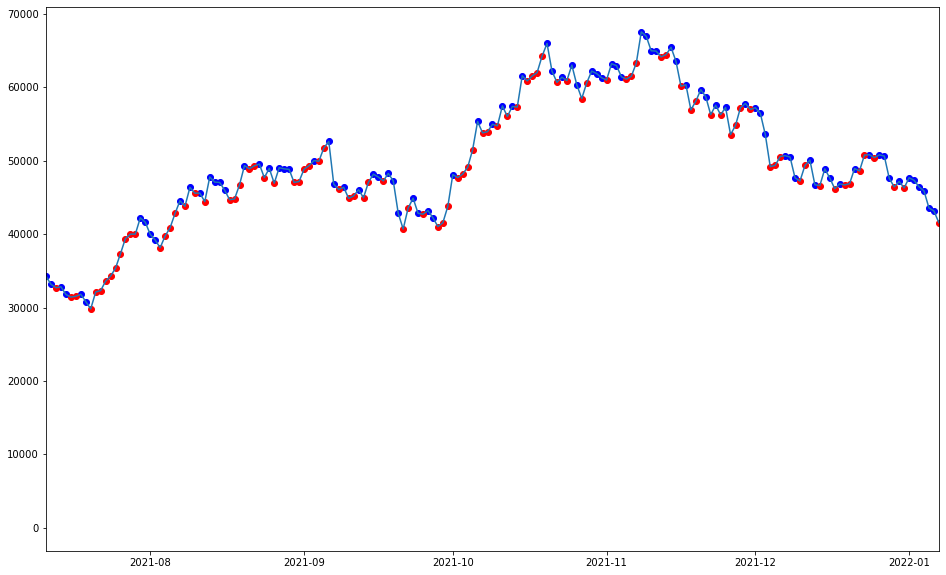

In [30]:
plot_point(target_long_point, target_short_point)

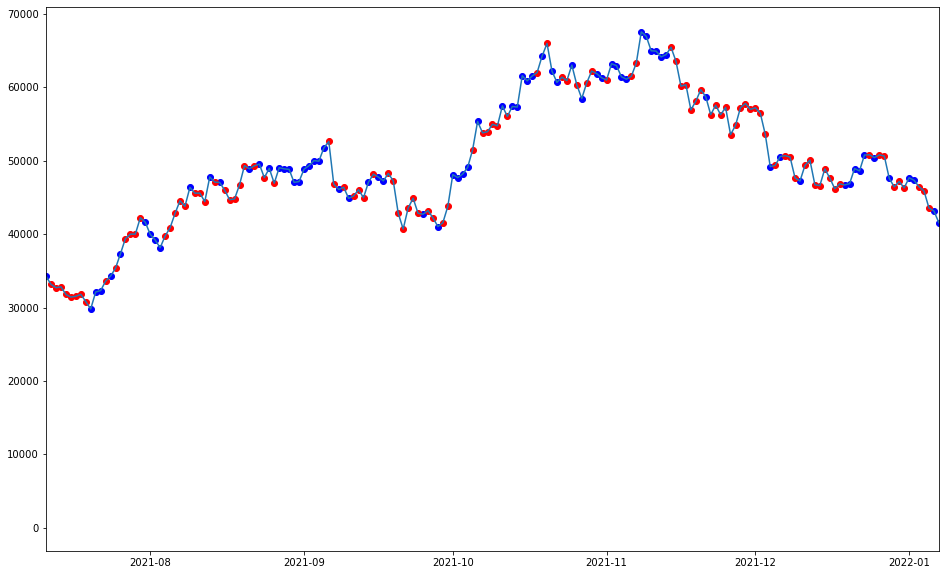

In [31]:
plot_point(long_point, short_point, 300)

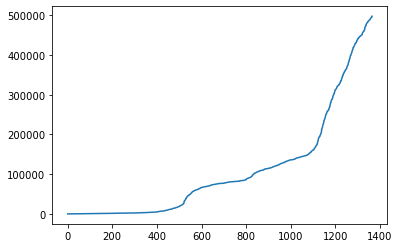

In [32]:
plt.plot(get_profit(target_long_point))

<b>단순한 매매로직</b>
* 단순하게 모델이 상승을 예측한 날에 매수를 하고 다음날 바로 매도하는 로직으로 매매를 진행해보자.
* 수익률은 일정 구간동안 괜찮은 모습을 보이다. 특정 기간에 크게 하락하는 모습을 보인다.
* 하락장에서 잘 대응하지 못하는 듯 보인다.

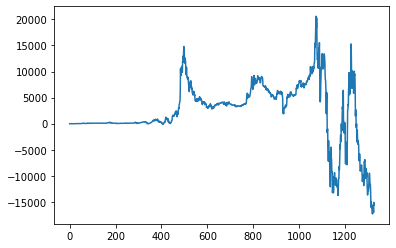

In [33]:
plt.plot(get_profit(long_point))

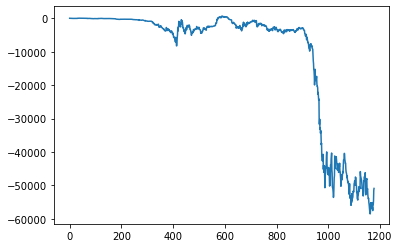

In [34]:
plt.plot(get_profit(short_point, is_short=True))

In [58]:
exp12 = pred_series.ewm(span = 6, adjust=False).mean()
exp26 = pred_series.ewm(span = 12, adjust=False).mean()
macd = exp12 - exp26
signal = macd.ewm(span=4, adjust=False).mean()



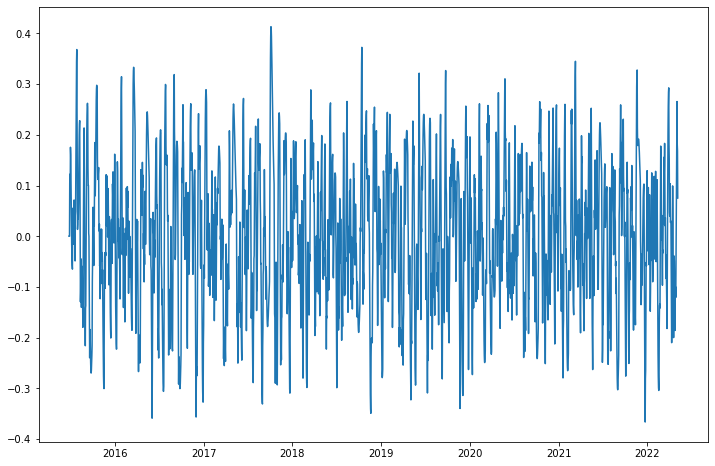

In [59]:
plt.figure(figsize=(12,8))
plt.plot(signal)

(18919.0, 18999.0)

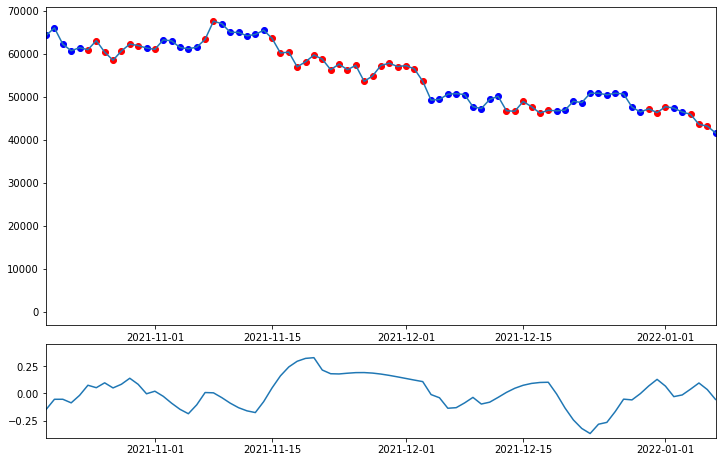

In [60]:
long_point = signal[signal > 0].index
short_point = signal[signal < 0].index
out_value = new_df['Adj Close'].loc[short_point]
in_value = new_df['Adj Close'].loc[long_point]

fig = plt.figure(figsize=(12,10))
ax_main = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
ax_sub = plt.subplot2grid((5, 1), (3, 0))



ax_main.plot(df['Adj Close'])
ax_main.scatter(x=short_point, y = out_value, c='b')
ax_main.scatter(x=long_point, y = in_value, c='r')
ax_main.set_xlim(new_df.index[-200], new_df.index[-SIZE])

ax_sub.plot(signal)
ax_sub.set_xlim(new_df.index[-200], new_df.index[-SIZE])


# plot_point(long_point, short_point)